In [1]:
%run funcs

cuda:1


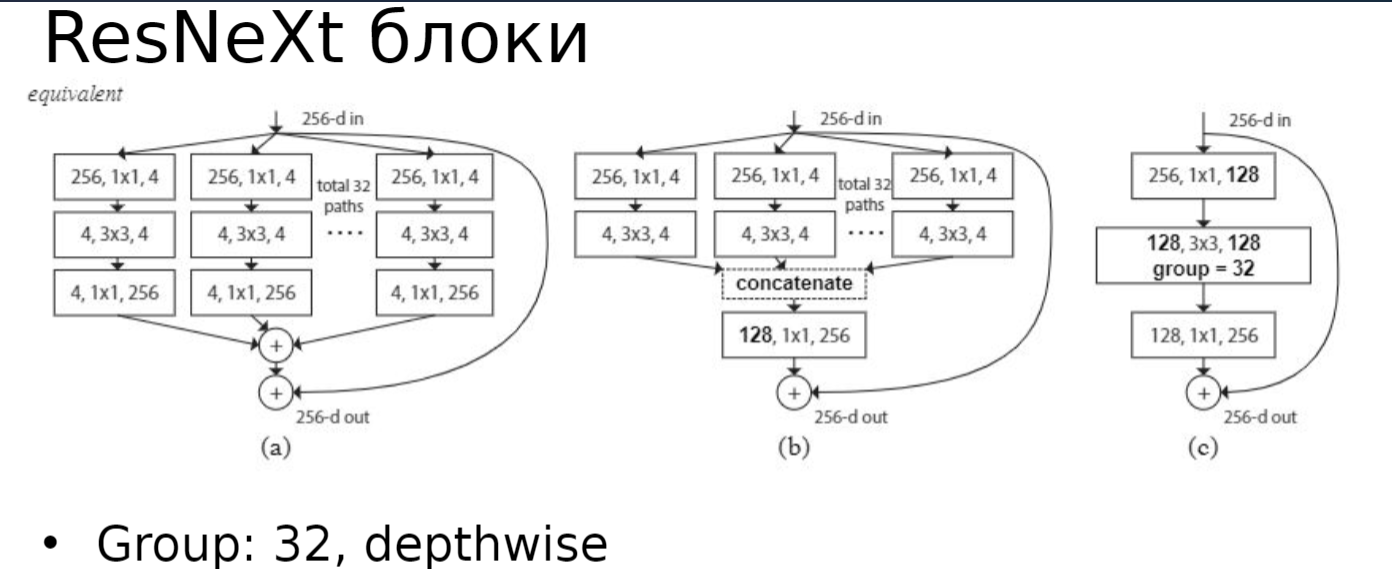

In [2]:
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
    
power = 4
bias_mask = False
class ResNet_Block_power(torch.nn.Module):
    def __init__(self,input_size, group_number):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask,
                           groups = group_number),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
a = torch.ones((512,5 ,32))
net_MC_data = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block_power(5, group_number = 5), #32
    ResNet_Block_power(5, group_number = 5), 
    Transition_Block(5), #16
    ResNet_Block_power(10, group_number = 10),
    ResNet_Block_power(10, group_number = 10), #16
    Transition_Block(10), #8
    ResNet_Block_power(20, group_number = 20),
    ResNet_Block_power(20, group_number = 20), 
    Transition_Block(20), #4
    ResNet_Block_power(40, group_number = 40),
    ResNet_Block_power(40, group_number = 40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160 ,2)
) 

print(net_MC_data(a).shape )
sum(p.numel() for p in net_MC_data.parameters()   )

torch.Size([512, 2])


69545

Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     Indeed Epoch =  11     Indeed Epoch =  12     Indeed Epoch =  13     Indeed Epoch =  14     Indeed Epoch =  15     Indeed Epoch =  16     Indeed Epoch =  17     Indeed Epoch =  18     Indeed Epoch =  19     Indeed Epoch =  20     Indeed Epoch =  21     Indeed Epoch =  22     Indeed Epoch =  23     Indeed Epoch =  24     Indeed Epoch =  25     

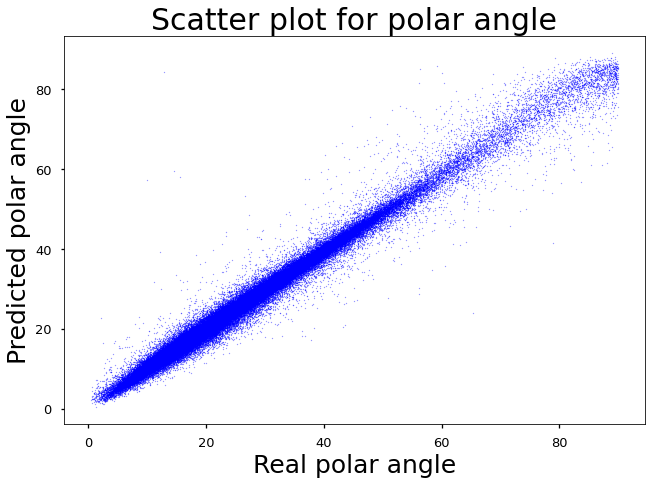

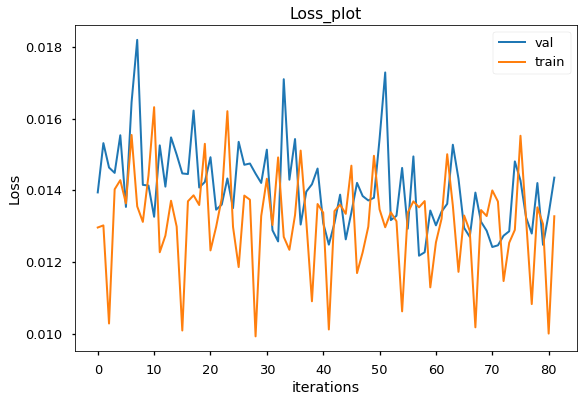

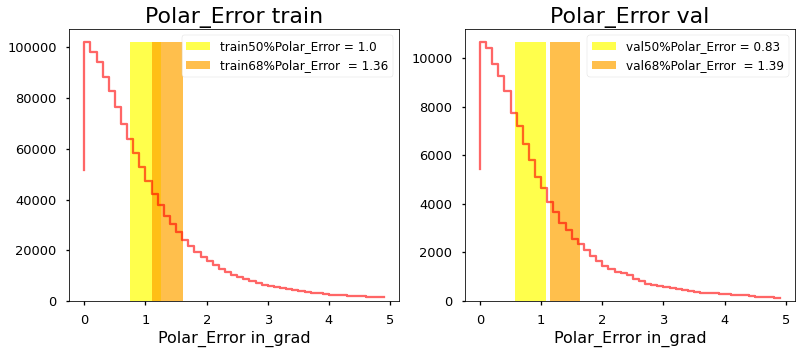

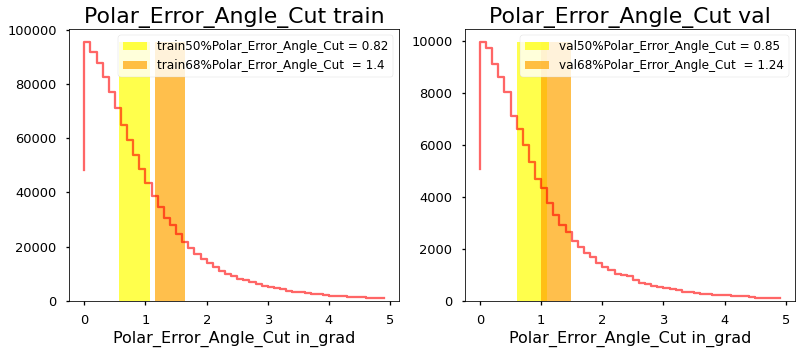

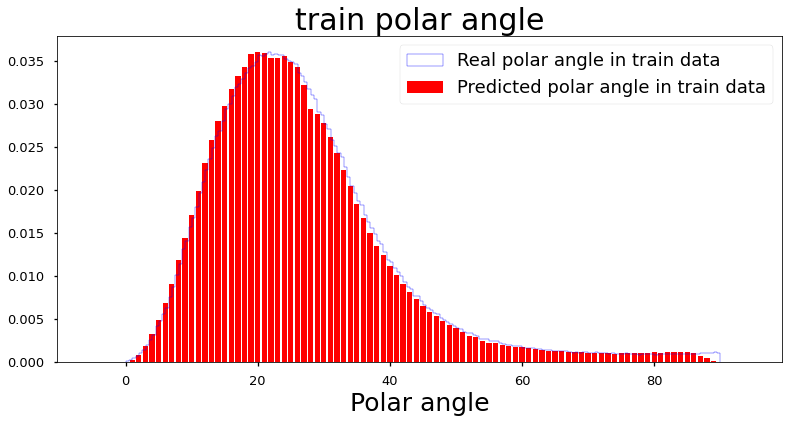

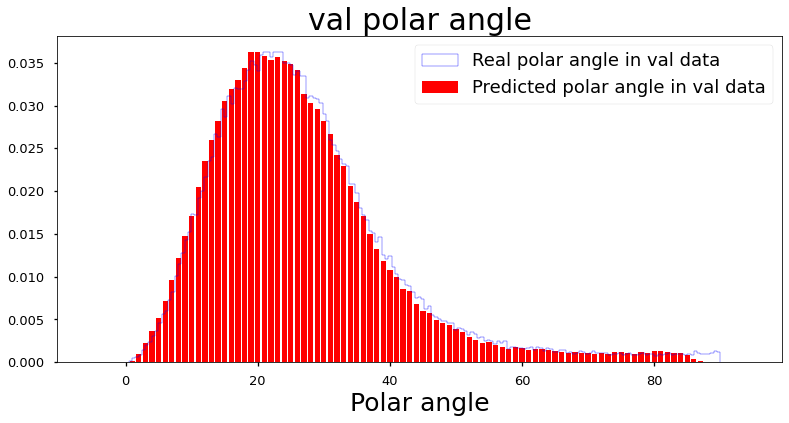

In [11]:
model = net_MC_data.to(device)
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1) 
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_only_polar_ResNeXt",
                                                                       epochs_num = 25, batch_size =128)

# Second Version

In [ ]:
class ResNeXt_Block_power(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.length = input_size
        self.conv_lists = [torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size//power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size//power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size//power, input_size//power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size//power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size//power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          ) for x in range(input_size)] 
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        outp = torch.zeros_like(inputs)
        for i in range(self.length):
            outp += self.conv_lists[i](inputs) 
        return  (outp +self.conv(inputs))

In [ ]:
net_MC_data_2 = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNeXt_Block_power(5), #32
    ResNeXt_Block_power(5), 
    Transition_Block(5), #16
    ResNeXt_Block_power(10),
    ResNeXt_Block_power(10), #16
    Transition_Block(10), #8
    ResNeXt_Block_power(20),
    ResNeXt_Block_power(20), 
    Transition_Block(20), #4
    ResNeXt_Block_power(40),
    ResNeXt_Block_power(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160 ,2)
) 

print(net_MC_data_2(a).shape )
sum(p.numel() for p in net_MC_data_2.parameters()   )

In [7]:
model_2 = net_MC_data_2.to(device)
opt = torch.optim.Adam(model_2.parameters(),lr=2e-3)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.975)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1) 
loss_lists, polar_hists ,polar_error =fitting(model_2, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_only_polar_ResNeXt_2",
                                                                       epochs_num = 25, batch_size =128)

NameError: name 'net_MC_data_2' is not defined

# Third version

In [ ]:
class ResNeXt_Block_power_concat(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.length = input_size
        self.conv_lists = [torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size//power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size//power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size//power, input_size//power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size//power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size//power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          ) for x in range(input_size)] 
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        outp = torch.zeros_like(inputs)
        for i in range(self.length):
            outp += self.conv_lists[i](inputs) 
        return  (outp +self.conv(inputs))